In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the model class
class LinearRegressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressor, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

class LogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [18]:
# Example Data (Replace with your actual data)
# X_train: tensor of shape [n_samples, n_features]
# y_train: tensor of shape [n_samples, 1]
#data generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/7cf3996c786ce33db90fcb7aef8584054169557c/src/notebooks/Selection_bias.ipynb


url = '/shared/share_mala/yuanzhe/adaptive_sampling/pipeline_datasets/'
csv_file = 'input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
#below is biased training data
csv_file =  '/biased_new/classifier_input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000_random_prop_score_selected_2_16.0__.csv'

directory = '/shared/share_mala/yuanzhe/adaptive_sampling/pipeline_datasets/'
train_csv_name = directory + 'classifier_input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
test_csv_name = directory + 'classifier_input_dim_1_test_final_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
pool_csv_name = directory + 'classifier_input_dim_1_pool_data_mean_0.0ln_1.0sig_0.1no.2000.csv'

file_list = [train_csv_name, test_csv_name, pool_csv_name]
name_list = ['train','test','pool']

df = pd.read_csv(url + csv_file)
X_train = np.array(df[['Column0']])
y_train = np.array(df[['EVENT_LABEL']])  
#y_train = y_train >0 #convert regression into classifier

# Convert data to PyTorch tensors if they aren't already
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Hyperparameters
epochs = 500  # Number of training iterations
learning_rate = 0.001

torch.manual_seed(123)

# Model, Loss and Optimizer
model = LogisticRegression(input_size=X_train.shape[1], output_size=1)
criterion = nn.MSELoss()
criterion = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train)
    
    #print test/ pool loss 
    #print X/Y train/ test/ pool
    # Compute and print loss
    loss = criterion(y_pred, y_train)
    if epoch % 10 == 0:  # Print every 10th epoch
        print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#torch.save(model, url + 'predictor.pkl')

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(url + 'predictor_0207.pt') # Save

#https://stackoverflow.com/questions/55488795/unpickling-saved-pytorch-model-throws-attributeerror-cant-get-attribute-net

Epoch 0, Loss: 0.776958167552948
Epoch 10, Loss: 0.7757589221000671
Epoch 20, Loss: 0.774570643901825
Epoch 30, Loss: 0.7733935117721558
Epoch 40, Loss: 0.7722272872924805
Epoch 50, Loss: 0.7710720896720886
Epoch 60, Loss: 0.7699275016784668
Epoch 70, Loss: 0.7687937617301941
Epoch 80, Loss: 0.7676705718040466
Epoch 90, Loss: 0.766558051109314
Epoch 100, Loss: 0.7654559016227722
Epoch 110, Loss: 0.7643642425537109
Epoch 120, Loss: 0.7632828950881958
Epoch 130, Loss: 0.7622115612030029
Epoch 140, Loss: 0.761150598526001
Epoch 150, Loss: 0.7600995302200317
Epoch 160, Loss: 0.7590585947036743
Epoch 170, Loss: 0.7580274939537048
Epoch 180, Loss: 0.7570062279701233
Epoch 190, Loss: 0.7559946179389954
Epoch 200, Loss: 0.7549927830696106
Epoch 210, Loss: 0.7540004849433899
Epoch 220, Loss: 0.7530176639556885
Epoch 230, Loss: 0.7520443201065063
Epoch 240, Loss: 0.751080334186554
Epoch 250, Loss: 0.750125527381897
Epoch 260, Loss: 0.749180018901825
Epoch 270, Loss: 0.7482435703277588
Epoch 280,

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def Recall_True(x_test, y_test, model, device): #input is dataloader_test and classifier/ model c, output is true recall given labels
 
    prediction_list = model(x_test)
    predicted_class = torch.argmax(prediction_list)
    predicted_class = prediction_list >= 0.5 #may need to use the previous code if model predicts probs of two classes
    x = torch.sum(torch.mul(y_test, predicted_class))
    y = torch.sum(y_test)
    return x/y

def compute_recall(csv_file):
    df = pd.read_csv(csv_file)
    X_test = np.array(df[['Column0']])
    y_test = np.array(df[['EVENT_LABEL']]) 
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    return float(Recall_True(X_test,y_test,model,device))
    
for i,f in enumerate(file_list):
    print('recall', name_list[i], compute_recall(f))


recall train 0.403940886259079
recall test 0.39351850748062134
recall pool 0.3695652186870575


In [18]:
#convert reg to classification, no need to run again
# url = '/shared/share_mala/yuanzhe/adaptive_sampling/pipeline_datasets/'
# train_csv_name = 'input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
# test_csv_name = 'input_dim_1_test_final_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
# pool_csv_name = 'input_dim_1_pool_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
# file_list  = [train_csv_name, test_csv_name, pool_csv_name]
# #convert y into 0/1

# for f in file_list:
#     df = pd.read_csv(url + f)
#     df['EVENT_LABEL'] = df['EVENT_LABEL'] > 0
#     df.to_csv(url+'classifier_'+ f, index = False)
# #/user/ym2865/Adaptive Sampling/src

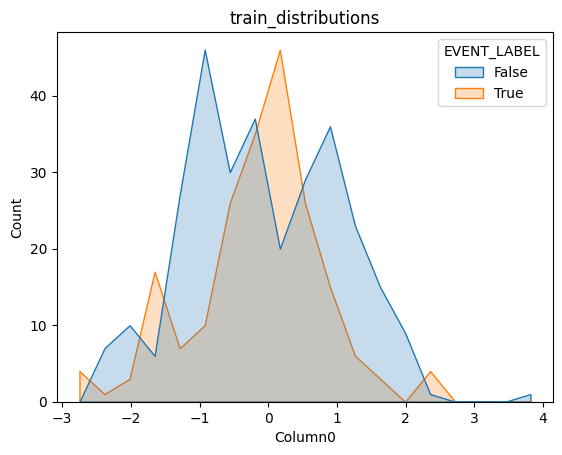

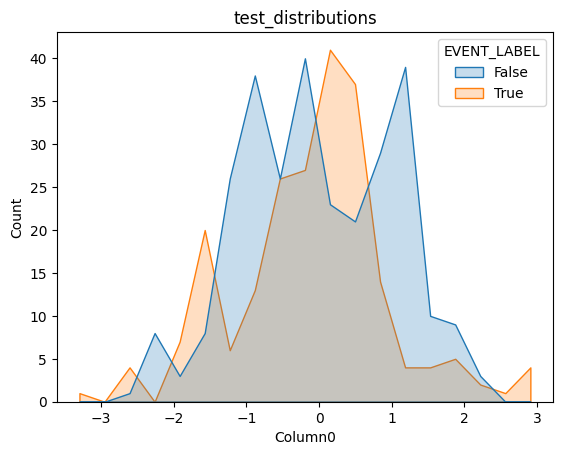

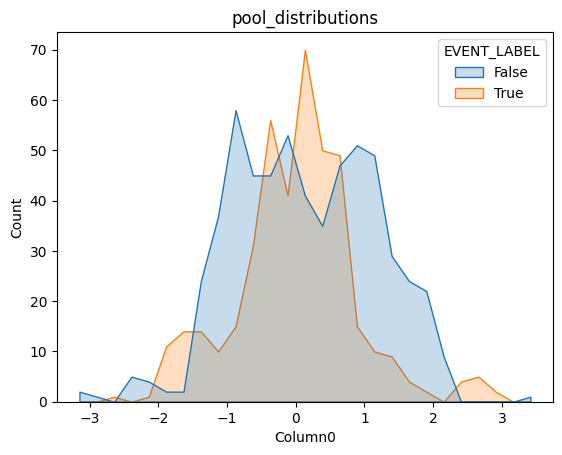

In [5]:
for i,f in enumerate(file_list):
    df = pd.read_csv(f)
    plt.title(name_list[i]+'_distributions')
    sns.histplot(df, x="Column0", hue="EVENT_LABEL", element="poly")

    plt.show()
    
